In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import utils
#import paint_auth as pa
from lxml import etree as ET
from collections import Counter
from sklearn.model_selection import train_test_split

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#import all xml and convert to pd dataframe
#only extract painters
info = pd.read_csv('mix_info.csv')

In [4]:
#getting labels
labels = list(info['style'])
labels = [int(l) for l in labels]
num_classes=len(set(labels))
path = './data/mix/'

#getting file_names
file_names = list(info['file_name'])
file_names = [path + n for n in file_names]

In [5]:
#processing training and val dataset
train_file_names, val_file_names, train_labels, val_labels = train_test_split(file_names, labels, test_size=0.2)

In [6]:
BATCH_SIZE=128

#train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_file_names, train_labels))
train_dataset = train_dataset.map(utils.preprocess_image_flip)
train_dataset = train_dataset.shuffle(10000)
batch_train_dataset = train_dataset.batch(BATCH_SIZE)

#val dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_file_names, val_labels))
val_dataset = val_dataset.map(utils.val_preprocess_image)
batch_val_dataset = val_dataset.batch(BATCH_SIZE)

In [7]:
#setting up iterator for dataset
iterator = tf.data.Iterator.from_structure(batch_train_dataset.output_types,
                                                   batch_train_dataset.output_shapes)
images, labels = iterator.get_next()

train_init_op = iterator.make_initializer(batch_train_dataset)
val_init_op = iterator.make_initializer(batch_val_dataset)

# Indicates whether we are in training or in test mode
is_training = tf.placeholder(tf.bool)

In [8]:
#setting up pretrained resnet trained on Imagenet
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from resnet_v1 import resnet_v1_50
from resnet_utils import resnet_arg_scope

In [9]:
# tf.reset_default_graph()

In [10]:
#note graph init. should only be ran once, use above cell to reset graph to run more than once
with slim.arg_scope(resnet_arg_scope()): #default parameter
    logits, _ = resnet_v1_50(images, num_classes=None, spatial_squeeze=True, is_training=is_training) #initialize model

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
#loading from checkpoint
ckpt_path = './checkpoint/resnet/resnet_v1_50.ckpt'
#exclude output layer as it has different class size
variables_to_restore = tf.contrib.framework.get_variables_to_restore()
init_fn = tf.contrib.framework.assign_from_checkpoint_fn(ckpt_path, variables_to_restore) #call to load weights

In [12]:
fc1_size = 128
with tf.name_scope('resnet_v1_50') as scope:
    fc1 = tf.layers.dense(logits, fc1_size, tf.nn.relu, name='fc1')
    output = tf.layers.dense(fc1, num_classes, tf.nn.softmax, name='output')

In [13]:
#define optimizers and loss
#optimizers initialized multiple times for each specific set of weights
alpha = 1e-4
alpha2 = 1e-5
one_hot_labels = tf.one_hot(labels, num_classes)
tf.losses.softmax_cross_entropy(one_hot_labels, output) #allows easy access for loss from tf.GraphKeys.losses
loss = tf.losses.get_total_loss()

fc_output_optimizer = tf.train.AdamOptimizer(alpha)
fc_output_variables = tf.contrib.framework.get_variables('fc1') + tf.contrib.framework.get_variables('output')
#train only last 2 fully connected
fc_output_op = fc_output_optimizer.minimize(loss, var_list=fc_output_variables)

#train all weights using same optimizer
full_optimizer = tf.train.GradientDescentOptimizer(alpha2)
full_train_op = full_optimizer.minimize(loss)

In [14]:
#evals
predictions = tf.to_int32(tf.argmax(output, 1))
correct_predictions = tf.equal(predictions, labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [15]:
#graph read only
# tf.get_default_graph().finalize()

In [16]:
def get_predictions(sess, predictions, is_training, dataset_train_op):
    sess.run(dataset_train_op)
    predictions_all = []
    while True: #run while non-empty iterator
        try:
            predictions_all.append(sess.run(predictions, {is_training:False}))
        except tf.errors.OutOfRangeError:
            break
        
    return predictions_all

In [17]:
def get_loss(sess, loss, is_training, data_init_op):
    sess.run(data_init_op)
    loss_all = []
    while True:
        try:
            loss_all.append(sess.run(loss, {is_training: False}))
        except tf.errors.OutOfRangeError:
            break
    return np.mean(loss_all)

In [18]:
def check_accuracy(sess, correct_prediction, is_training, dataset_init_op):
    """
    Check the accuracy of the model on either train or val (depending on dataset_init_op).
    """
    # Initialize the correct dataset
    sess.run(dataset_init_op)
    num_correct, num_samples = 0, 0
    while True:
        try:
            correct_pred = sess.run(correct_prediction, {is_training: False})
            num_correct += correct_pred.sum()
            num_samples += correct_pred.shape[0]
        except tf.errors.OutOfRangeError:
            break

    # Return the fraction of datapoints that were correctly classified
    acc = float(num_correct) / num_samples
    return acc

In [19]:
#initializing session and bookeeping vars
sess = tf.Session()
print 'initialize new variables...'
sess.run(tf.global_variables_initializer())
init_fn(sess)
epochs = 5000
train_acc_all = []
val_acc_all = []
train_loss_all = []
val_loss_all = []

initialize new variables...
INFO:tensorflow:Restoring parameters from ./checkpoint/resnet/resnet_v1_50.ckpt


Starting epoch: 1 / 5000
training... done
Train Acc./Loss: 0.599265 / 0.968035
Val. Acc./Loss: 0.544118 / 0.987454


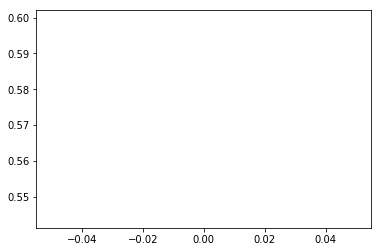

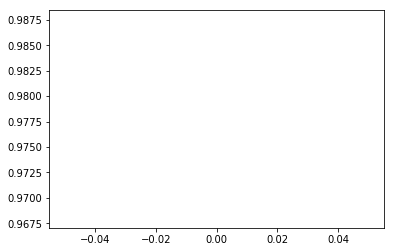

Starting epoch: 2 / 5000
training... done
Train Acc./Loss: 0.658088 / 0.967160
Val. Acc./Loss: 0.500000 / 0.983887


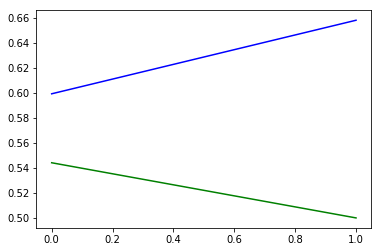

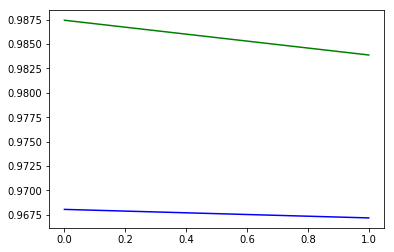

Starting epoch: 3 / 5000
training... done
Train Acc./Loss: 0.643382 / 0.948053
Val. Acc./Loss: 0.514706 / 0.981907


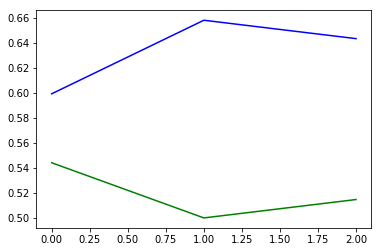

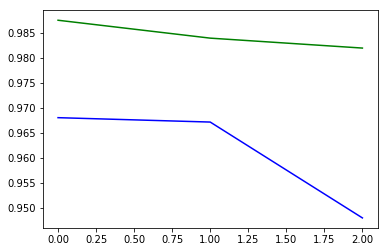

Starting epoch: 4 / 5000
training... done
Train Acc./Loss: 0.628676 / 0.950770
Val. Acc./Loss: 0.500000 / 0.981297


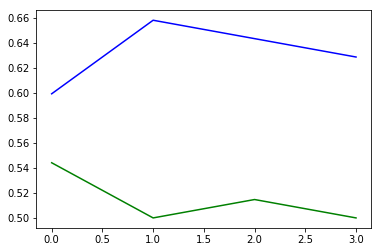

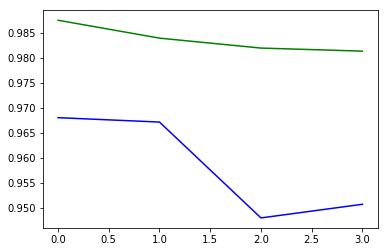

Starting epoch: 5 / 5000
training... done
Train Acc./Loss: 0.632353 / 0.951015
Val. Acc./Loss: 0.544118 / 0.982883


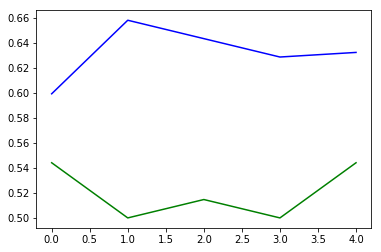

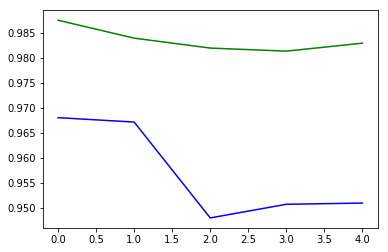

Starting epoch: 6 / 5000
training... done
Train Acc./Loss: 0.591912 / 0.951098
Val. Acc./Loss: 0.514706 / 0.986607


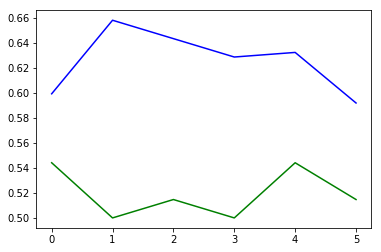

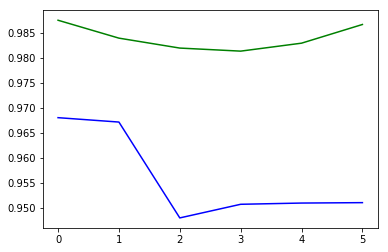

Starting epoch: 7 / 5000
training... done
Train Acc./Loss: 0.577206 / 0.919253
Val. Acc./Loss: 0.500000 / 0.989062


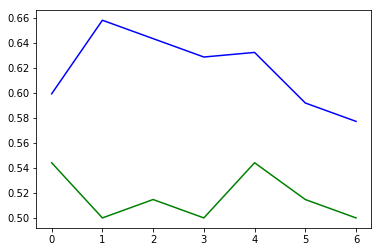

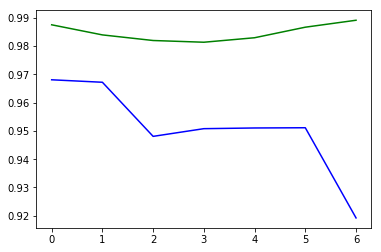

Starting epoch: 8 / 5000
training... done
Train Acc./Loss: 0.599265 / 0.954775
Val. Acc./Loss: 0.514706 / 0.985169


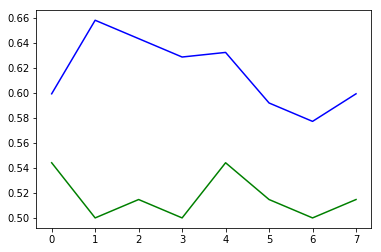

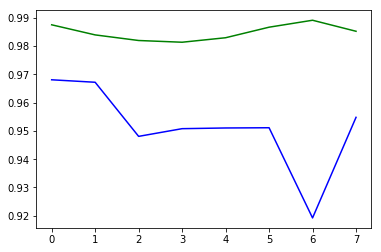

Starting epoch: 9 / 5000
training... done
Train Acc./Loss: 0.613971 / 0.960398
Val. Acc./Loss: 0.529412 / 0.982802


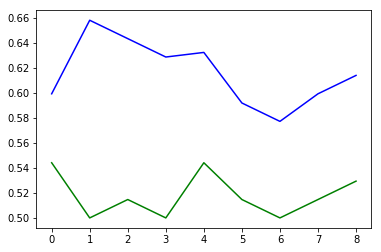

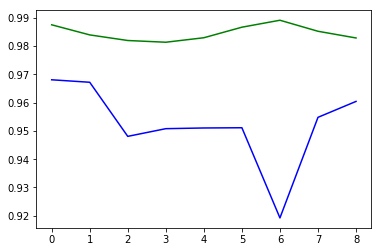

Starting epoch: 10 / 5000
training... done
Train Acc./Loss: 0.621324 / 0.960080
Val. Acc./Loss: 0.514706 / 0.981486


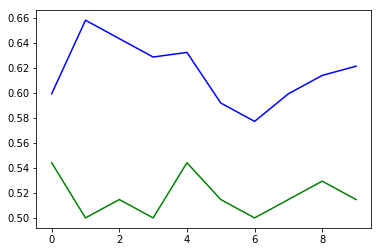

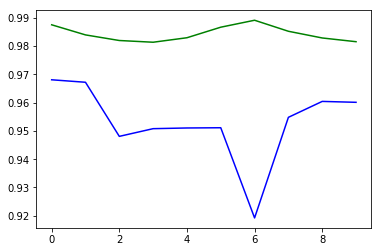

Starting epoch: 11 / 5000
training... done
Train Acc./Loss: 0.606618 / 0.937104
Val. Acc./Loss: 0.529412 / 0.980653


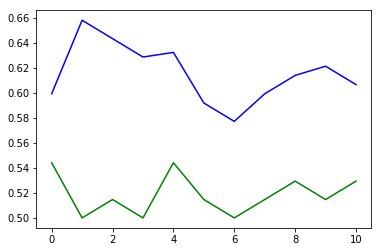

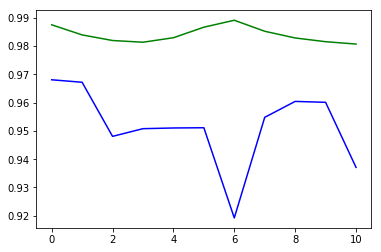

Starting epoch: 12 / 5000
training... done
Train Acc./Loss: 0.628676 / 0.931045
Val. Acc./Loss: 0.529412 / 0.981397


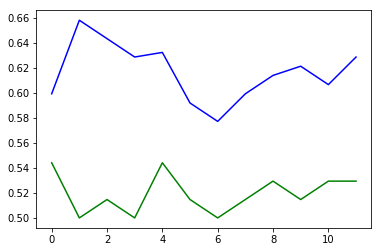

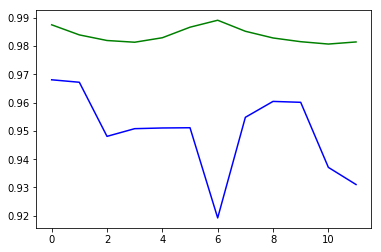

Starting epoch: 13 / 5000
training... done
Train Acc./Loss: 0.621324 / 0.937214
Val. Acc./Loss: 0.529412 / 0.982696


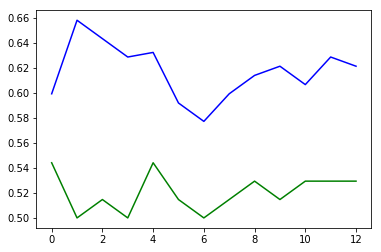

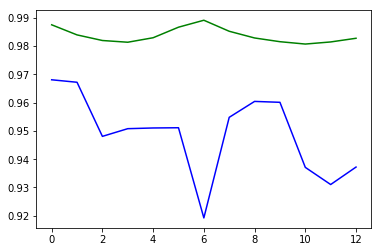

Starting epoch: 14 / 5000
training... done
Train Acc./Loss: 0.602941 / 0.954724
Val. Acc./Loss: 0.514706 / 0.985736


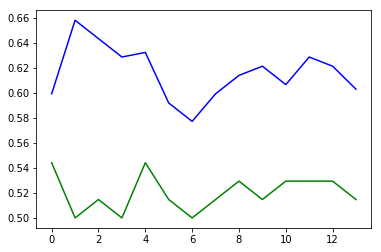

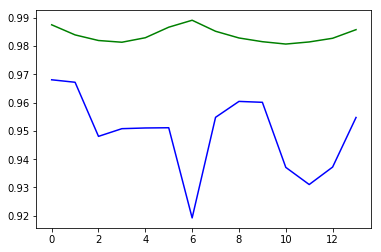

Starting epoch: 15 / 5000
training... done
Train Acc./Loss: 0.599265 / 0.931701
Val. Acc./Loss: 0.514706 / 0.987496


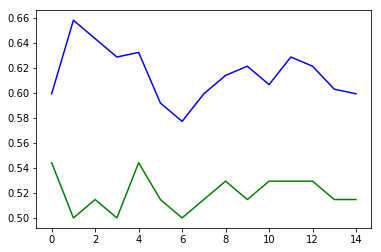

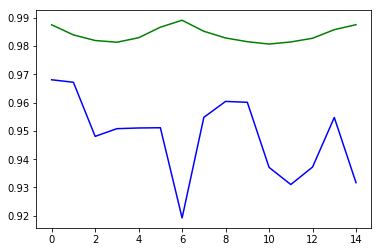

Starting epoch: 16 / 5000
training... done
Train Acc./Loss: 0.602941 / 0.935031
Val. Acc./Loss: 0.500000 / 0.984936


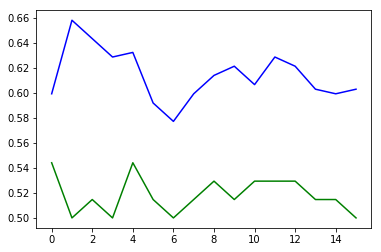

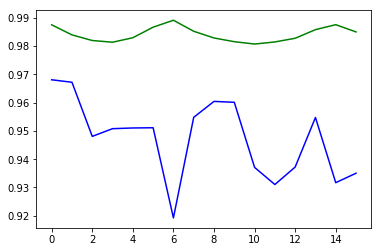

Starting epoch: 17 / 5000
training... done
Train Acc./Loss: 0.647059 / 0.912376
Val. Acc./Loss: 0.514706 / 0.979747


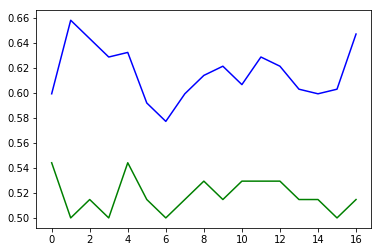

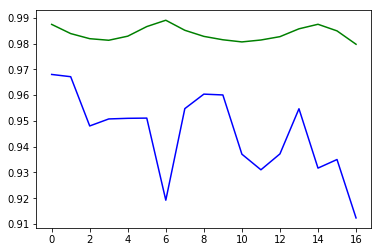

Starting epoch: 18 / 5000
training... done
Train Acc./Loss: 0.687500 / 0.934411
Val. Acc./Loss: 0.529412 / 0.975895


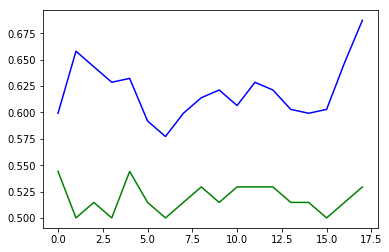

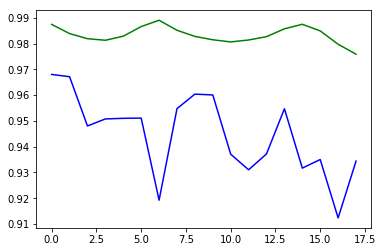

Starting epoch: 19 / 5000
training... done
Train Acc./Loss: 0.676471 / 0.932587
Val. Acc./Loss: 0.544118 / 0.974238


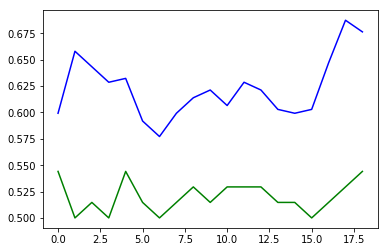

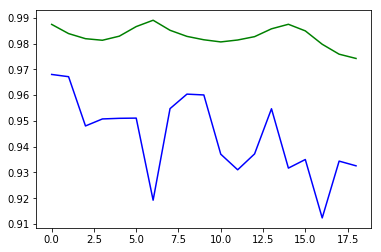

Starting epoch: 20 / 5000
training... done
Train Acc./Loss: 0.687500 / 0.918186
Val. Acc./Loss: 0.573529 / 0.973590


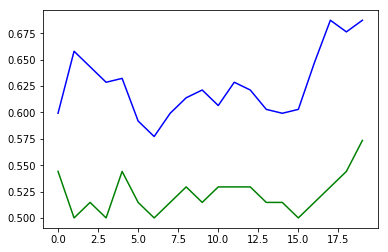

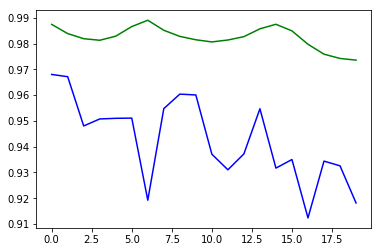

Starting epoch: 21 / 5000
training... done
Train Acc./Loss: 0.683824 / 0.943132
Val. Acc./Loss: 0.558824 / 0.973296


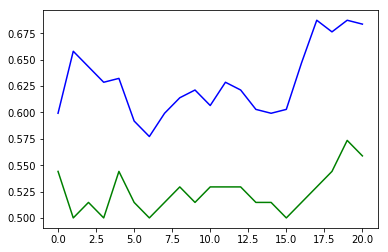

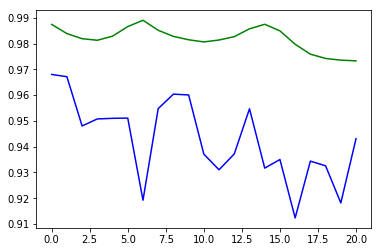

Starting epoch: 22 / 5000
training... done
Train Acc./Loss: 0.691176 / 0.941778
Val. Acc./Loss: 0.558824 / 0.974216


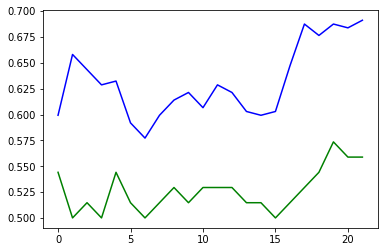

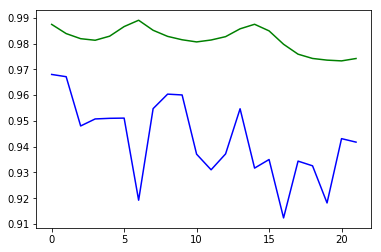

Starting epoch: 23 / 5000
training... done
Train Acc./Loss: 0.705882 / 0.928145
Val. Acc./Loss: 0.573529 / 0.974224


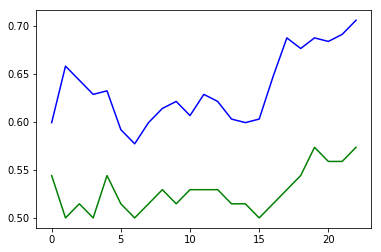

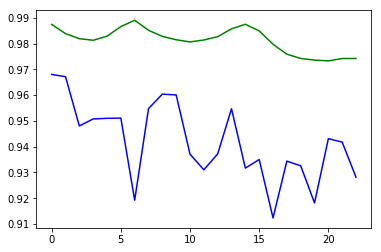

Starting epoch: 24 / 5000
training... done
Train Acc./Loss: 0.680147 / 0.928425
Val. Acc./Loss: 0.544118 / 0.974998


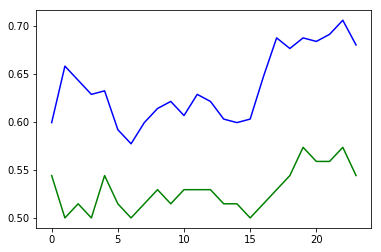

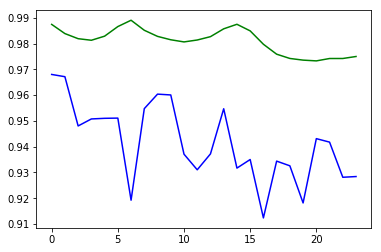

Starting epoch: 25 / 5000
training... done
Train Acc./Loss: 0.654412 / 0.937092
Val. Acc./Loss: 0.544118 / 0.977608


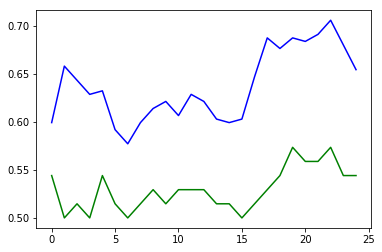

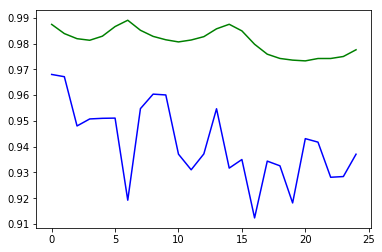

Starting epoch: 26 / 5000
training... done
Train Acc./Loss: 0.650735 / 0.905544
Val. Acc./Loss: 0.544118 / 0.977471


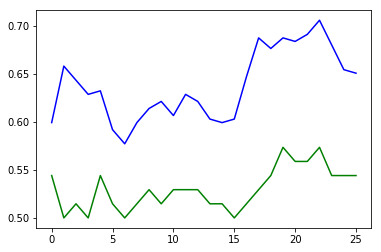

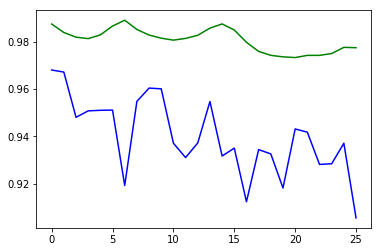

Starting epoch: 27 / 5000
training... done
Train Acc./Loss: 0.661765 / 0.923906
Val. Acc./Loss: 0.573529 / 0.976043


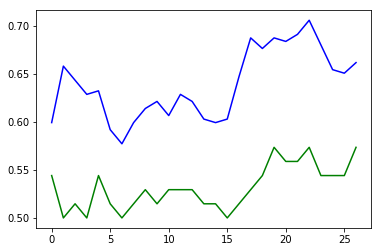

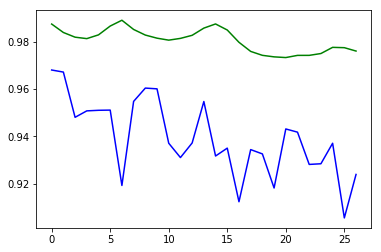

Starting epoch: 28 / 5000
training... done
Train Acc./Loss: 0.698529 / 0.917276
Val. Acc./Loss: 0.558824 / 0.975674


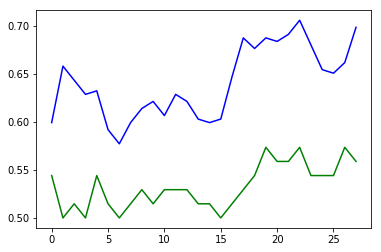

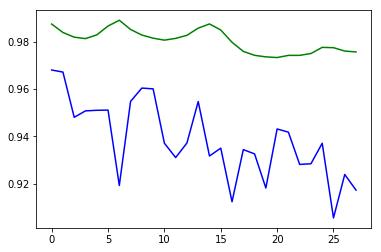

Starting epoch: 29 / 5000
training... done
Train Acc./Loss: 0.702206 / 0.913970
Val. Acc./Loss: 0.602941 / 0.975540


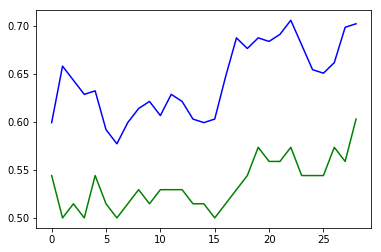

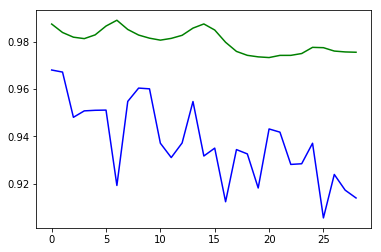

Starting epoch: 30 / 5000
training... done
Train Acc./Loss: 0.694853 / 0.938201
Val. Acc./Loss: 0.573529 / 0.975395


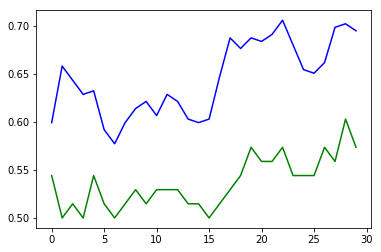

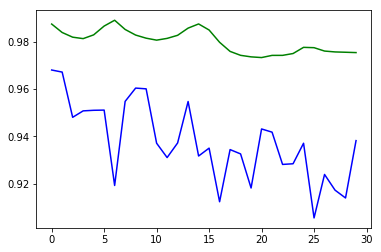

Starting epoch: 31 / 5000
training... done
Train Acc./Loss: 0.672794 / 0.931742
Val. Acc./Loss: 0.573529 / 0.975272


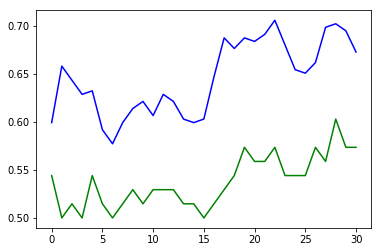

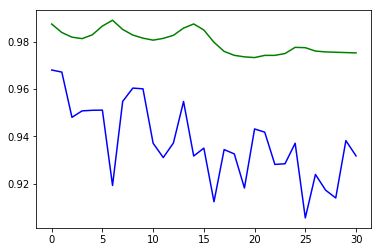

Starting epoch: 32 / 5000
training... done
Train Acc./Loss: 0.694853 / 0.925581
Val. Acc./Loss: 0.573529 / 0.975229


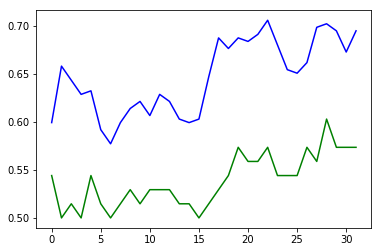

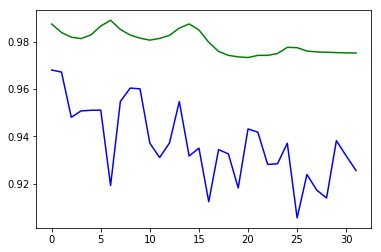

Starting epoch: 33 / 5000
training... done
Train Acc./Loss: 0.709559 / 0.893460
Val. Acc./Loss: 0.558824 / 0.974958


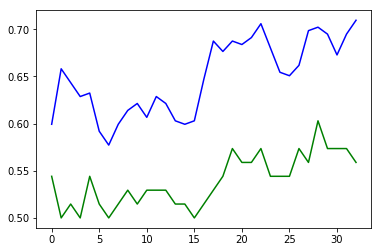

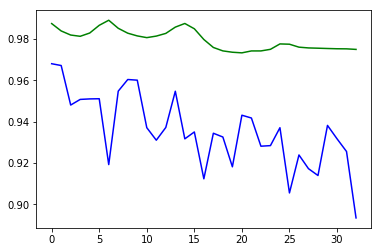

Starting epoch: 34 / 5000
training... done
Train Acc./Loss: 0.727941 / 0.928561
Val. Acc./Loss: 0.573529 / 0.973914


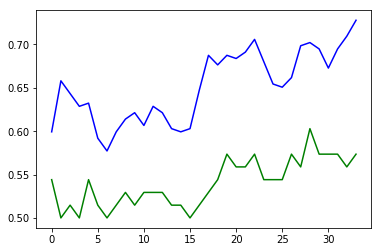

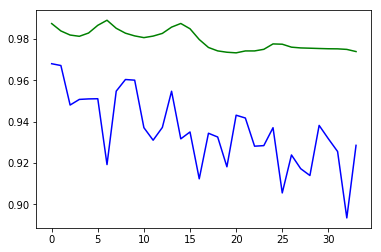

Starting epoch: 35 / 5000
training... done
Train Acc./Loss: 0.709559 / 0.925707
Val. Acc./Loss: 0.573529 / 0.973442


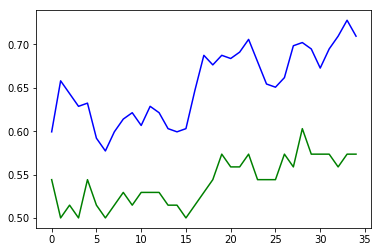

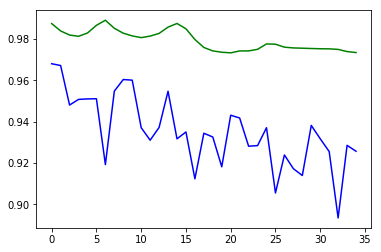

Starting epoch: 36 / 5000
training... done
Train Acc./Loss: 0.687500 / 0.921822
Val. Acc./Loss: 0.573529 / 0.973439


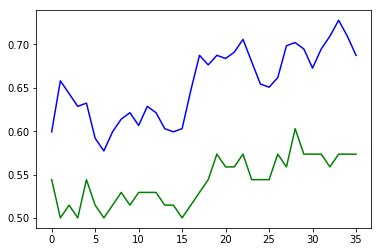

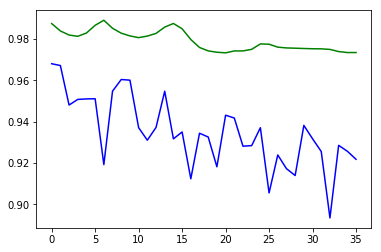

Starting epoch: 37 / 5000
training... done
Train Acc./Loss: 0.687500 / 0.929473
Val. Acc./Loss: 0.573529 / 0.973384


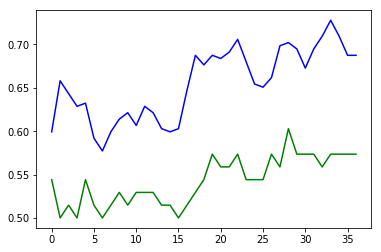

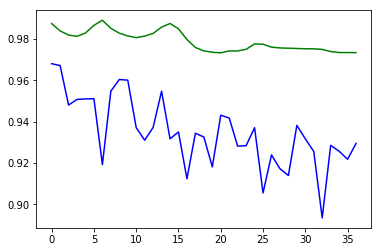

Starting epoch: 38 / 5000
training... done
Train Acc./Loss: 0.672794 / 0.913707
Val. Acc./Loss: 0.573529 / 0.972786


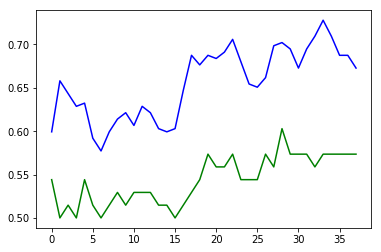

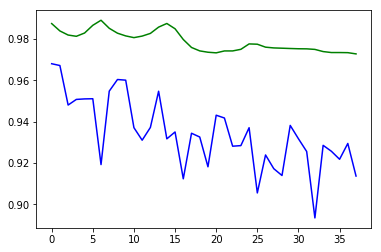

Starting epoch: 39 / 5000
training... done
Train Acc./Loss: 0.709559 / 0.912371
Val. Acc./Loss: 0.588235 / 0.971405


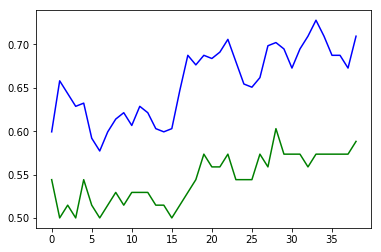

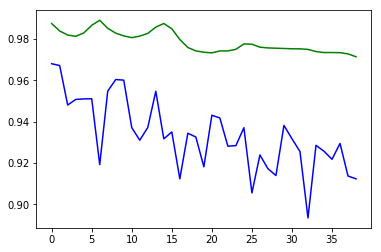

Starting epoch: 40 / 5000
training... done
Train Acc./Loss: 0.676471 / 0.922755
Val. Acc./Loss: 0.588235 / 0.970672


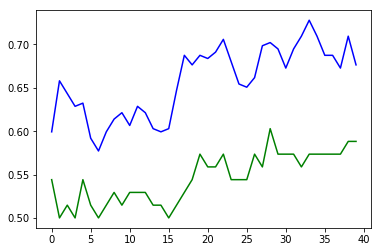

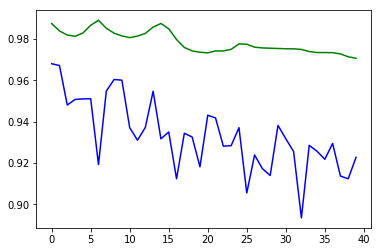

Starting epoch: 41 / 5000
training... done
Train Acc./Loss: 0.680147 / 0.933193
Val. Acc./Loss: 0.617647 / 0.970562


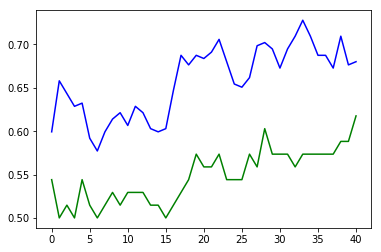

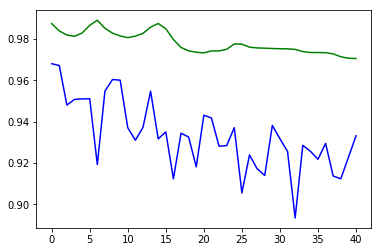

Starting epoch: 42 / 5000
training... done
Train Acc./Loss: 0.720588 / 0.903572
Val. Acc./Loss: 0.617647 / 0.970530


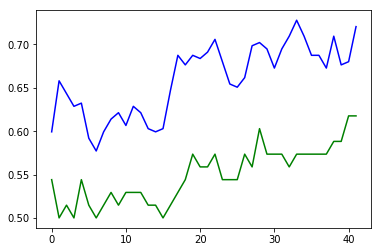

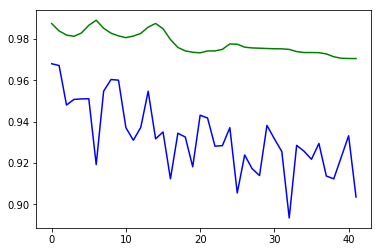

Starting epoch: 43 / 5000
training... done
Train Acc./Loss: 0.691176 / 0.903183
Val. Acc./Loss: 0.588235 / 0.971423


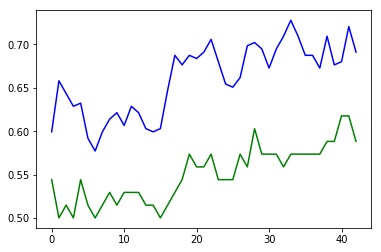

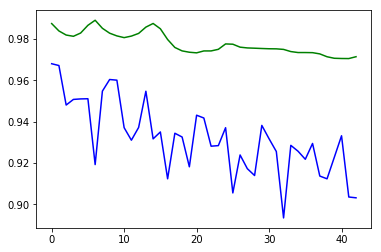

Starting epoch: 44 / 5000
training... done
Train Acc./Loss: 0.665441 / 0.907264
Val. Acc./Loss: 0.529412 / 0.974259


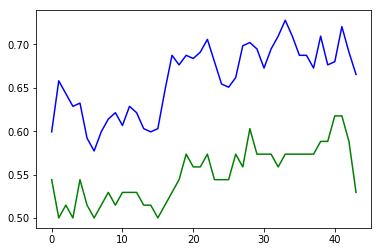

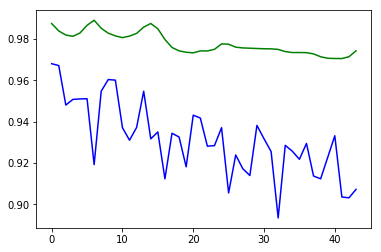

Starting epoch: 45 / 5000
training... done
Train Acc./Loss: 0.665441 / 0.932873
Val. Acc./Loss: 0.544118 / 0.977613


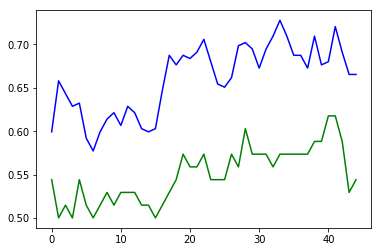

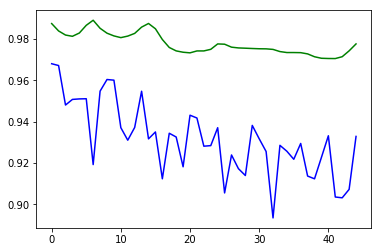

Starting epoch: 46 / 5000
training... done
Train Acc./Loss: 0.647059 / 0.912615
Val. Acc./Loss: 0.544118 / 0.979623


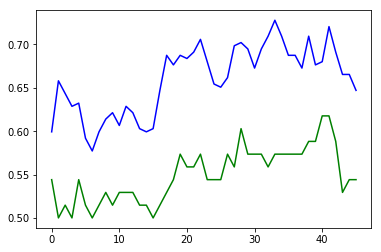

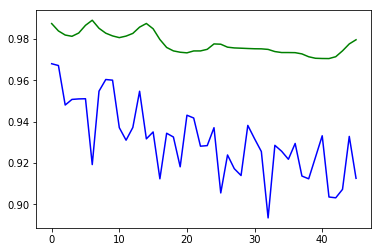

Starting epoch: 47 / 5000
training... done
Train Acc./Loss: 0.650735 / 0.922828
Val. Acc./Loss: 0.544118 / 0.979993


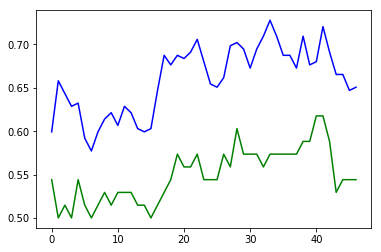

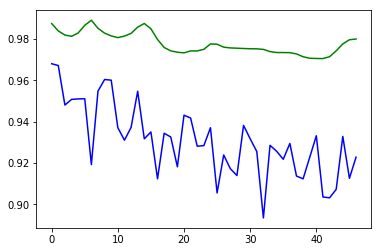

Starting epoch: 48 / 5000
training... done
Train Acc./Loss: 0.654412 / 0.934622
Val. Acc./Loss: 0.514706 / 0.976107


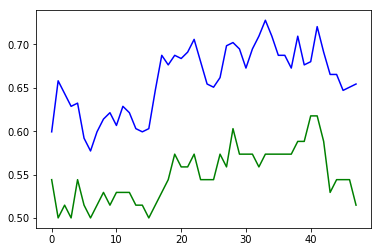

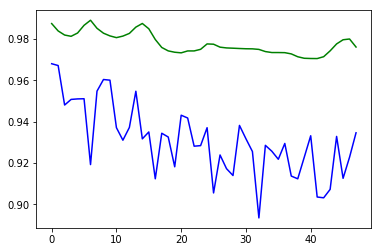

Starting epoch: 49 / 5000
training...

KeyboardInterrupt: 

In [20]:
#begin training for the logit/auxlogit layers 
for ep in range(epochs):
    
    #starting training set iterator
    print 'Starting epoch: %d / %d' % (ep + 1, epochs)
    sess.run(train_init_op)
    print 'training...',
    while True: #run while iterator is non-empty
        try:
            _ = sess.run(fc_output_op, {is_training:True})
#             _ = sess.run(full_train_op, {is_training:True})
        except tf.errors.OutOfRangeError:
            break
        
    print 'done'
        #train and val. acc
#     train_acc = check_accuracy(sess, accuracy, is_training, train_init_op)
#     val_acc = check_accuracy(sess, accuracy, is_training, val_init_op)
        
    train_acc = check_accuracy(sess, correct_predictions, is_training, train_init_op)
    val_acc = check_accuracy(sess, correct_predictions, is_training, val_init_op)
    train_loss = get_loss(sess, loss, is_training, train_init_op)
    val_loss = get_loss(sess, loss, is_training, val_init_op)
    
    print 'Train Acc./Loss: %f / %f' % (train_acc, train_loss)
    print 'Val. Acc./Loss: %f / %f' % (val_acc, val_loss)
        
    train_acc_all.append(train_acc)
    val_acc_all.append(val_acc)
    train_loss_all.append(train_loss)
    val_loss_all.append(val_loss)
    
        
    #plotting
    t = range(len(train_acc_all))
    plt.plot(t, train_acc_all, 'b')
    plt.plot(t, val_acc_all, 'g')
    plt.show()
    
    #plotting loss
    t = range(len(train_loss_all))
    plt.plot(t, train_loss_all, 'b')
    plt.plot(t, val_loss_all, 'g')
    plt.show()

In [21]:
def get_pred_labels(sess, predictions, labels, is_training, dataset_train_op):
    sess.run(dataset_train_op)
    pred_all = []
    labels_all = []
    while True: #run while non-empty iterator
        try:
            pred_all.append(sess.run(predictions, {is_training:False}))
        except tf.errors.OutOfRangeError:
            break
    sess.run(dataset_train_op)
    while True: #run while non-empty iterator
        try:
            labels_all.append(sess.run(labels))
        except tf.errors.OutOfRangeError:
            break
    return pred_all, labels_all

In [23]:
my_pred, my_labels = get_pred_labels(sess, predictions, labels, is_training, val_init_op)

In [29]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
cnf_matrix = confusion_matrix(my_labels[0], my_pred[0])

In [35]:
cnf_matrix

array([[25,  8],
       [24, 11]])

In [36]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.75757576 0.24242424]
 [0.68571429 0.31428571]]


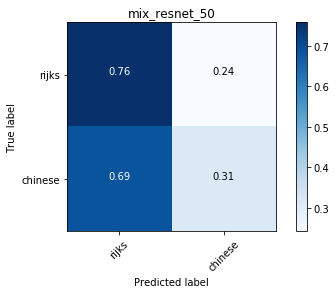

In [38]:
plot_confusion_matrix(cnf_matrix, ['rijks', 'chinese'], True, 'mix_resnet_50')